In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
import cv2
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
import warnings
warnings.filterwarnings('ignore')

C:\Users\laura\anaconda3\envs\EntornoGPU\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\laura\anaconda3\envs\EntornoGPU\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\laura\anaconda3\envs\EntornoGPU\lib\site-packages\numpy\.libs\libopenblas.wcdjnk7yvmpzq2me2zzhjjrj3jikndb7.gfortran-win_amd64.dll
C:\Users\laura\anaconda3\envs\EntornoGPU\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# 1. EDA
# 1.1 Carga, visualización y emparejado de Datos

In [2]:
# Cargar datos en LOCAL
df = pd.read_csv('Details of samples EN.csv', encoding='latin-1', delimiter=";")

df.head()

,Location,Season,Sampling,Event number,Sample number,The number of sample,Image,FT-IR,Lost,Broken,diameter / mm,area / mm^2,estimated mass / µg,Color,Shape,Component,Remark,Product,Remark.1,Note
0,Ubon Ratchathani,Dry Season,Accumulation Sampling,502,1,1,0502-0001.jpg,0502-0001-air-ATR.JDX,NaN,NaN,"6,33","2,14","128,61",red,Fiber,PP,NaN,NaN,NaN,NaN
1,Ubon Ratchathani,Dry Season,Accumulation Sampling,502,2,1,0502-0002.jpg,0502-0002-air-ATR.JDX,NaN,NaN,"6,53","1,72","103,21",white,Fiber,PP,??,NaN,NaN,NaN
2,Ubon Ratchathani,Dry Season,Accumulation Sampling,502,3,1,0502-0003.jpg,0502-0003-air-ATR.JDX,NaN,NaN,"5,75","9,12","1168,15",white,Fiber,PET,NaN,NaN,NaN,NaN
3,Ubon Ratchathani,Dry Season,Accumulation Sampling,502,5,1,0502-0005.jpg,0502-0005-air-ATR.JDX,NaN,NaN,"2,24","0,80","101,94",white,Fiber,PU,polyetherurethane,NaN,NaN,NaN
4,Ubon Ratchathani,Dry Season,Accumulation Sampling,502,6,1,0502-0006.jpg,0502-0006-air-ATR.JDX,NaN,NaN,"0,97","0,29",-,green,Fragment,Not Plastic,No similar plastics,NaN,NaN,NaN


In [3]:
# Seleccion columnas
columns_to_keep = ['Image', 'diameter / mm', 'Color', 'Shape', 'Component']
df_filtered = df[columns_to_keep]

df_filtered.head()

,Image,diameter / mm,Color,Shape,Component
0,0502-0001.jpg,"6,33",red,Fiber,PP
1,0502-0002.jpg,"6,53",white,Fiber,PP
2,0502-0003.jpg,"5,75",white,Fiber,PET
3,0502-0005.jpg,"2,24",white,Fiber,PU
4,0502-0006.jpg,"0,97",green,Fragment,Not Plastic


In [4]:
# Función para cargar y redimensionar + array de NumPy
def load_and_resize_image(image_path, target_size=(299, 299)):
    try:
        with Image.open(image_path) as img:
            img_resized = img.resize(target_size)
            img_array = np.array(img_resized)
            img_array_normalized = img_array.astype('float32') / 255.0
            return img_array_normalized
    except IOError:
        print(f"No se pudo cargar la imagen: {image_path}")
        return None

# Función crear el dataset
def create_dataset(data_df, images_folder):
    dataset = []
    # Eliminar NaN en 'Image'
    data_df = data_df.dropna(subset=['Image'])
    for index, row in data_df.iterrows():
        image_filename = str(row['Image'])  # str
        image_path = os.path.join(images_folder, image_filename)
        image = load_and_resize_image(image_path, target_size=(299, 299))
        if image is not None:
            image_data = (image,
                          row['diameter / mm'],
                          row['Color'],
                          row['Shape'],
                          row['Component'])
            dataset.append(image_data)
    return dataset


images_folder = r"C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images"
df_with_images = create_dataset(df_filtered, images_folder)

No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0502-0001.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0502-0002.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0502-0003.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0502-0005.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0502-0006.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\-
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0502-0014.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL

No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0541-0012.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\-
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0543-0001.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0543-0006.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0543-0007.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0543-0008.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0543-0009.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL

No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0615-0051.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0615-0052.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0615-0053.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0615-0054.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0615-0055.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0615-0056.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0615-0057.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUN

No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0624-0001.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0624-0002.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0624-0004.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0624-0005.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0624-0006.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0624-0007.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0624-0008.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUN

No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\-
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0673-0002.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\-
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\-
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\-
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0673-0057.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0673-0058.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1

No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0693-0012.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0695-0011.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0695-0030.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0695-0039.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0695-0040.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0697-0050.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUNDA PARTE DEL CURSO\PROYECTO FINAL\PROTOTIPOS\V 1.0\Images\0700-0010.jpg
No se pudo cargar la imagen: C:\Users\laura\Python Laura\SEGUN

In [5]:
print(len(df_with_images))

2569


In [6]:
type(df_with_images)

list

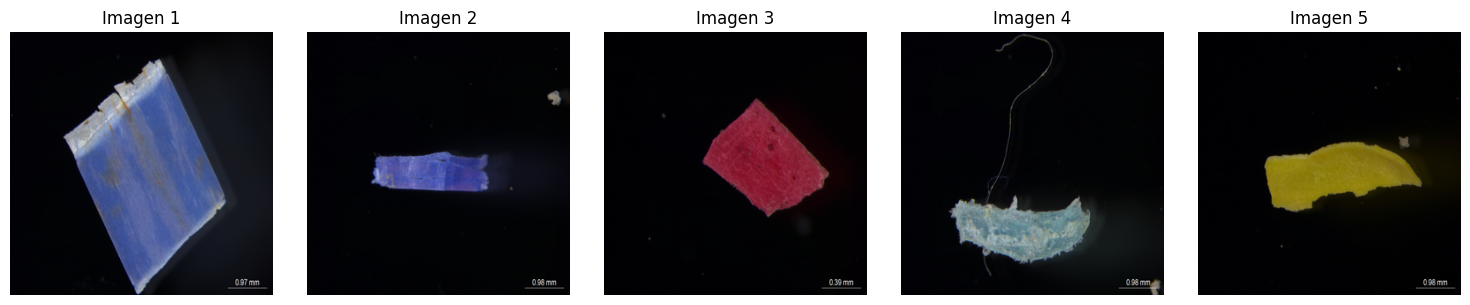

In [7]:
# Mostrar las primeras 5 imágenes para comprobar
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))  # 5 columnas para 5 imágenes

for i, ax in enumerate(axes.flat):
    image, *metadata = df_with_images[i]
    ax.imshow(image)
    ax.set_title(f"Imagen {i+1}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# 1.2 Tratamiento y preparación de Datos

In [8]:
columns = [f'Columna{i+1}' for i in range(len(df_with_images[0]))]
print(columns)

['Columna1', 'Columna2', 'Columna3', 'Columna4', 'Columna5']


In [9]:
df_nuevo = pd.DataFrame(df_with_images, columns=['Columna1', 'Columna2', 'Columna3', 'Columna4', 'Columna5'])

In [10]:
df_nuevo.columns = ['Image_normalized', 'diameter / mm', "Color","Shape", "Component"]

In [11]:
df_nuevo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2569 entries, 0 to 2568
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Image_normalized  2569 non-null   object
 1   diameter / mm     2569 non-null   object
 2   Color             2569 non-null   object
 3   Shape             2569 non-null   object
 4   Component         2567 non-null   object
dtypes: object(5)
memory usage: 100.5+ KB


In [12]:
df_nuevo.head(3)

,Image_normalized,diameter / mm,Color,Shape,Component
0,"[[[0.050980393, 0.05882353, 0.05882353], [0.04...","4,42",blue,Sheet,PP
1,"[[[0.007843138, 0.007843138, 0.023529412], [0....","2,94",blue,Sheet,PP
2,"[[[0.003921569, 0.003921569, 0.015686275], [0....","1,26",red,Sheet,PP


In [13]:
print("-"*60)
print("Total muestras: {}".format(df_nuevo.shape[0]))
print("Total clases:{}".format(df_nuevo["Shape"].nunique()))
print("Total componentes:{}".format(df_nuevo["Component"].nunique()))

------------------------------------------------------------
Total muestras: 2569
Total clases:6
Total componentes:17


In [14]:
# Limpiamos los datos
df_nuevo['diameter / mm'].replace('-', np.nan, inplace=True)
df_nuevo['diameter / mm'] = df_nuevo['diameter / mm'].str.replace(',', '.')
df_nuevo['diameter / mm'] = df_nuevo['diameter / mm'].astype(float)

In [15]:
df_nuevo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2569 entries, 0 to 2568
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Image_normalized  2569 non-null   object 
 1   diameter / mm     2567 non-null   float64
 2   Color             2569 non-null   object 
 3   Shape             2569 non-null   object 
 4   Component         2567 non-null   object 
dtypes: float64(1), object(4)
memory usage: 100.5+ KB


In [16]:
df_nuevo = df_nuevo.dropna(subset=["Shape", "Component"])
df_nuevo = df_nuevo.dropna(subset=["diameter / mm"])

In [17]:
rows_to_drop = df_nuevo[df_nuevo['Shape'].str.contains("-")].index
df_nuevo = df_nuevo.drop(rows_to_drop)
rows_to_drop = df_nuevo[df_nuevo['Component'].str.contains("-")].index
df_nuevo = df_nuevo.drop(rows_to_drop)

In [18]:
df_nuevo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2543 entries, 0 to 2568
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Image_normalized  2543 non-null   object 
 1   diameter / mm     2543 non-null   float64
 2   Color             2543 non-null   object 
 3   Shape             2543 non-null   object 
 4   Component         2543 non-null   object 
dtypes: float64(1), object(4)
memory usage: 119.2+ KB


# 1.3 Tratamiento Columna Shape

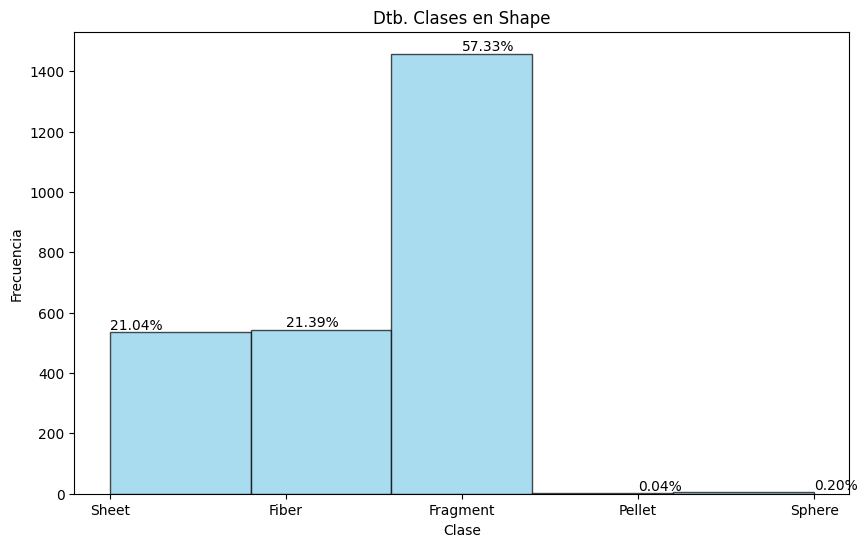

In [19]:
def plot_class_histogram(data_df, title):
    class_counts = data_df["Shape"].value_counts()
    total_samples = len(data_df)
    percentages = (class_counts / total_samples) * 100

    plt.figure(figsize=(10, 6))
    plt.hist(data_df["Shape"], bins=len(class_counts), color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel('Clase')
    plt.ylabel('Frecuencia')

    for i, (class_name, count) in enumerate(class_counts.items()):
        percentage = percentages[class_name]
        plt.text(class_name, count, f'{percentage:.2f}%', va='bottom')

    plt.show()

plot_class_histogram(df_nuevo, 'Dtb. Clases en Shape')

In [20]:
# Descartamos Pellet y Sphere
df_nuevo = df_nuevo[~df_nuevo['Shape'].isin(["Pellet", "Sphere"])]

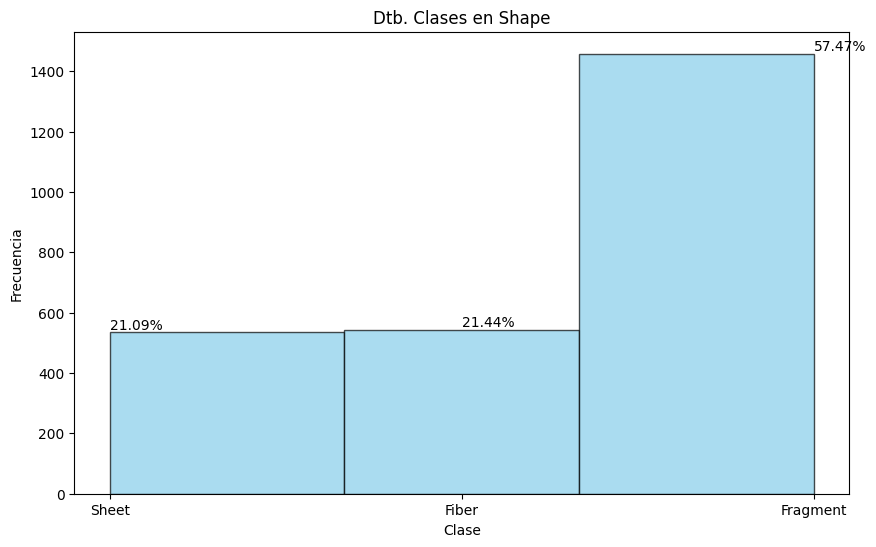

In [21]:
def plot_class_histogram(data_df, title):
    class_counts = data_df["Shape"].value_counts()
    total_samples = len(data_df)
    percentages = (class_counts / total_samples) * 100

    plt.figure(figsize=(10, 6))
    plt.hist(data_df["Shape"], bins=len(class_counts), color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel('Clase')
    plt.ylabel('Frecuencia')

    for i, (class_name, count) in enumerate(class_counts.items()):
        percentage = percentages[class_name]
        plt.text(class_name, count, f'{percentage:.2f}%', va='bottom')

    plt.show()

plot_class_histogram(df_nuevo, 'Dtb. Clases en Shape')

# 1.4 Tratamiento Columna Component

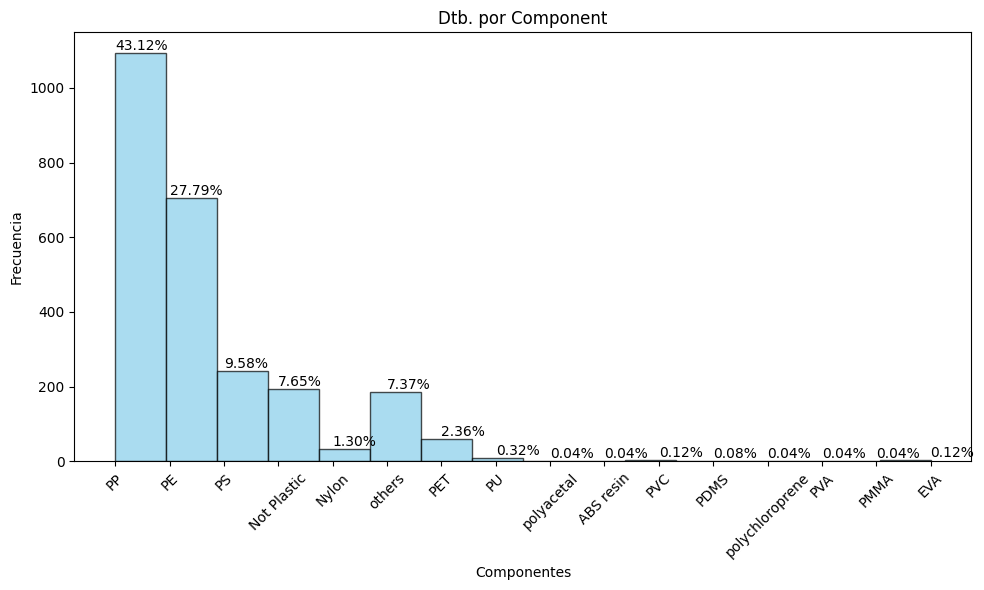

In [22]:
def plot_components_histogram(data_df, title):
    component_counts = data_df["Component"].value_counts()
    component_counts = data_df["Component"].value_counts()
    total_samples = len(data_df)
    percentages = (component_counts / total_samples) * 100

    plt.figure(figsize=(10, 6))
    plt.hist(data_df["Component"], bins=len(component_counts), color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel('Componentes')
    plt.ylabel('Frecuencia')

    for i, (component_name, count) in enumerate(component_counts.items()):
        percentage = percentages[component_name]
        plt.text(component_name, count, f'{percentage:.2f}%', va='bottom')

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

plot_components_histogram(df_nuevo, 'Dtb. por Component')

In [23]:
# Visualizamos numero de muestras
print(df_nuevo["Component"].value_counts())

PP                 1094
PE                  705
PS                  243
Not Plastic         194
others              187
PET                  60
Nylon                33
PU                    8
PVC                   3
EVA                   3
PDMS                  2
polyacetal            1
ABS resin             1
polychloroprene       1
PVA                   1
PMMA                  1
Name: Component, dtype: int64


In [24]:
# Descartamos PU, PVC, EVA, PDMS, Polyacetal, ABS, Polychloroprene, PVA y PMMA | Nos quedamos con los componentes que tengan 25 o más muestras
suma_por_componente = df_nuevo['Component'].value_counts()
componentes_filtrados = suma_por_componente[suma_por_componente >= 25].index
df_nuevo = df_nuevo[df_nuevo['Component'].isin(componentes_filtrados)]

In [25]:
print(df_nuevo["Component"].value_counts())

PP             1094
PE              705
PS              243
Not Plastic     194
others          187
PET              60
Nylon            33
Name: Component, dtype: int64


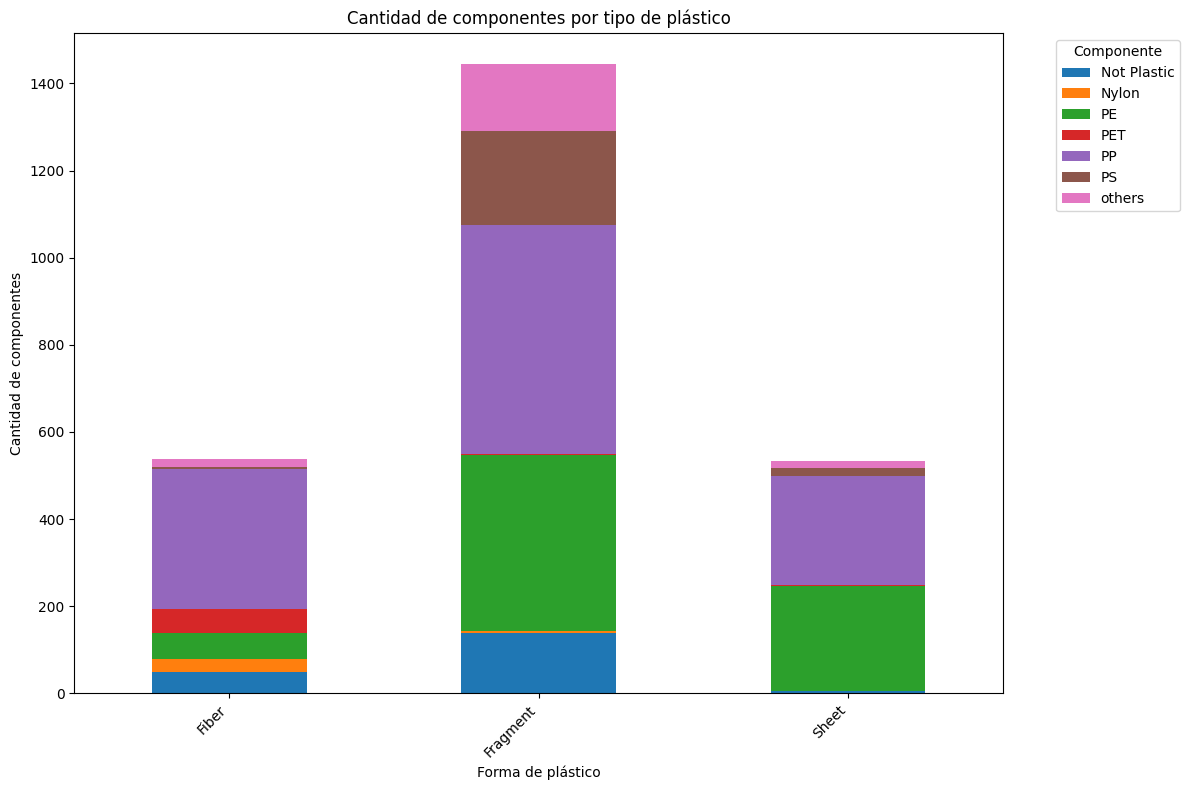

In [26]:
# Ahora visualizamos cuántos componentes por cada forma de plástico hay
componentes_por_tipo_plastico = df_nuevo.groupby(['Shape', 'Component']).size().unstack(fill_value=0)
componentes_por_tipo_plastico.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Cantidad de componentes por tipo de plástico')
plt.xlabel('Forma de plástico')
plt.ylabel('Cantidad de componentes')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Componente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

In [27]:
# visualizamos cantidad de componentes por forma de plástico
clases_distintas = df_nuevo['Shape'].nunique()
componentes_por_tipo_plastico = df_nuevo.groupby('Shape')['Component'].value_counts()

print(componentes_por_tipo_plastico)

Shape     Component  
Fiber     PP             320
          PE              59
          PET             56
          Not Plastic     49
          Nylon           30
          others          18
          PS               6
Fragment  PP             524
          PE             406
          PS             217
          others         153
          Not Plastic    139
          Nylon            3
          PET              2
Sheet     PP             250
          PE             240
          PS              20
          others          16
          Not Plastic      6
          PET              2
Name: Component, dtype: int64


# 1.5 Tratamiento Columna diameter / mm

In [28]:
# Visualizamos el diámetro
def plot_boxplot(data, column_name):
    plt.figure(figsize=(8, 6))

    column_data = data[column_name].dropna()
    plt.boxplot(column_data, vert=False)
    plt.title('Boxplot de {}'.format(column_name))
    plt.xlabel(column_name)
    plt.grid(True)

    plt.show()

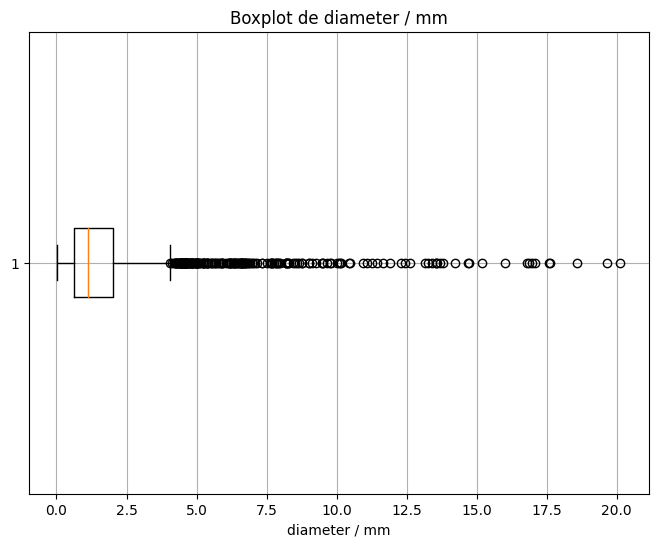

In [29]:
plot_boxplot(df_nuevo, 'diameter / mm')

In [30]:
df_nuevo['diameter / mm'].describe()

count    2516.000000
mean        1.761904
std         2.156438
min         0.010000
25%         0.640000
50%         1.130000
75%         2.000000
max        20.130000
Name: diameter / mm, dtype: float64

In [31]:
df_nuevo.head()

,Image_normalized,diameter / mm,Color,Shape,Component
0,"[[[0.050980393, 0.05882353, 0.05882353], [0.04...",4.42,blue,Sheet,PP
1,"[[[0.007843138, 0.007843138, 0.023529412], [0....",2.94,blue,Sheet,PP
2,"[[[0.003921569, 0.003921569, 0.015686275], [0....",1.26,red,Sheet,PP
3,"[[[0.003921569, 0.003921569, 0.023529412], [0....",4.63,blue,Sheet,PE
4,"[[[0.003921569, 0.003921569, 0.019607844], [0....",3.95,yellow,Sheet,PP


# 1.6 Transformar Diametros de mm a μm

In [32]:
df_nuevo['Diameter / µm'] = df_nuevo['diameter / mm'] * 1000
df_nuevo.drop(columns=['diameter / mm'], inplace=True)
df_nuevo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2516 entries, 0 to 2568
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Image_normalized  2516 non-null   object 
 1   Color             2516 non-null   object 
 2   Shape             2516 non-null   object 
 3   Component         2516 non-null   object 
 4   Diameter / µm     2516 non-null   float64
dtypes: float64(1), object(4)
memory usage: 117.9+ KB


In [33]:
df_nuevo.head(2)

,Image_normalized,Color,Shape,Component,Diameter / µm
0,"[[[0.050980393, 0.05882353, 0.05882353], [0.04...",blue,Sheet,PP,4420.0
1,"[[[0.007843138, 0.007843138, 0.023529412], [0....",blue,Sheet,PP,2940.0


# 1.7 Agregando Columna Category, que depende del Diámetro

In [34]:
# Función para asignar categoría
def asignar_categoria(diametro):
    if diametro >= 0.001 and diametro <= 1:
        return 'Nanoplastic'
    elif diametro > 1 and diametro <= 1000:
        return 'Microplastic'
    elif diametro > 1000 and diametro <= 10000:
        return 'Mesoplastic'
    elif diametro > 10000:
        return 'Macroplastic'

In [35]:
df_nuevo['Category'] = df_nuevo['Diameter / µm'].apply(asignar_categoria)

In [36]:
df_nuevo.head(2)

,Image_normalized,Color,Shape,Component,Diameter / µm,Category
0,"[[[0.050980393, 0.05882353, 0.05882353], [0.04...",blue,Sheet,PP,4420.0,Mesoplastic
1,"[[[0.007843138, 0.007843138, 0.023529412], [0....",blue,Sheet,PP,2940.0,Mesoplastic


In [37]:
print("-"*60)
print("Total muestras: {}".format(df_nuevo.shape[0]))
print("Total clases:{}".format(df_nuevo["Shape"].nunique()))
print("Total componentes:{}".format(df_nuevo["Component"].nunique()))
print("Total colores:{}".format(df_nuevo["Color"].nunique()))
print("Total categorías:{}".format(df_nuevo["Category"].nunique()))

------------------------------------------------------------
Total muestras: 2516
Total clases:3
Total componentes:7
Total colores:12
Total categorías:3


In [38]:
# Nos aseguramos de que los datos sean del tipo que necesitamos en todas las columnas
columnas_a_verificar = ['Image_normalized', 'Color', 'Shape', 'Component', 'Category']

for column in columnas_a_verificar:
    print(f"Columna: {column}")
    tipos = df_nuevo[column].apply(lambda x: type(x).__name__).value_counts()
    print(tipos)
    print("\n")

Columna: Image_normalized
ndarray    2516
Name: Image_normalized, dtype: int64


Columna: Color
str    2516
Name: Color, dtype: int64


Columna: Shape
str    2516
Name: Shape, dtype: int64


Columna: Component
str    2516
Name: Component, dtype: int64


Columna: Category
str    2516
Name: Category, dtype: int64




In [39]:
df_nuevo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2516 entries, 0 to 2568
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Image_normalized  2516 non-null   object 
 1   Color             2516 non-null   object 
 2   Shape             2516 non-null   object 
 3   Component         2516 non-null   object 
 4   Diameter / µm     2516 non-null   float64
 5   Category          2516 non-null   object 
dtypes: float64(1), object(5)
memory usage: 137.6+ KB


# 1.8 Tratamiento columna color

In [40]:
df_nuevo['Color'].value_counts()

white          1164
transparent     408
green           232
blue            215
yellow          152
red             111
black            84
multicolor       66
brown            58
orange           18
purple            7
White             1
Name: Color, dtype: int64

In [41]:
# Descartamos Colores
df_nuevo = df_nuevo[~df_nuevo['Color'].isin(['orange', 'purple', 'White'])]

In [42]:
df_nuevo['Color'].value_counts()

white          1164
transparent     408
green           232
blue            215
yellow          152
red             111
black            84
multicolor       66
brown            58
Name: Color, dtype: int64

# 2 Construcción del Modelo

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
%reload_ext tensorboard
import datetime
import warnings
warnings.filterwarnings('ignore')

## 2.1 Transformación variables categóricas

In [44]:
# Aplicar one-hot
shape_one_hot = pd.get_dummies(df_nuevo['Shape'], prefix='Shape')
color_one_hot = pd.get_dummies(df_nuevo['Color'], prefix='Color')
component_one_hot = pd.get_dummies(df_nuevo['Component'], prefix='Component')
category_one_hot = pd.get_dummies(df_nuevo['Category'], prefix='Category')

df_final_one_hot = df_nuevo.join([shape_one_hot, color_one_hot, component_one_hot, category_one_hot])

In [45]:
df_final_one_hot.head(3)

,Image_normalized,Color,Shape,Component,Diameter / µm,Category,Shape_Fiber,Shape_Fragment,Shape_Sheet,Color_black,...,Component_Not Plastic,Component_Nylon,Component_PE,Component_PET,Component_PP,Component_PS,Component_others,Category_Macroplastic,Category_Mesoplastic,Category_Microplastic
0,"[[[0.050980393, 0.05882353, 0.05882353], [0.04...",blue,Sheet,PP,4420.0,Mesoplastic,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,"[[[0.007843138, 0.007843138, 0.023529412], [0....",blue,Sheet,PP,2940.0,Mesoplastic,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
2,"[[[0.003921569, 0.003921569, 0.015686275], [0....",red,Sheet,PP,1260.0,Mesoplastic,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0


In [46]:
df_final_one_hot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2490 entries, 0 to 2568
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Image_normalized       2490 non-null   object 
 1   Color                  2490 non-null   object 
 2   Shape                  2490 non-null   object 
 3   Component              2490 non-null   object 
 4   Diameter / µm          2490 non-null   float64
 5   Category               2490 non-null   object 
 6   Shape_Fiber            2490 non-null   uint8  
 7   Shape_Fragment         2490 non-null   uint8  
 8   Shape_Sheet            2490 non-null   uint8  
 9   Color_black            2490 non-null   uint8  
 10  Color_blue             2490 non-null   uint8  
 11  Color_brown            2490 non-null   uint8  
 12  Color_green            2490 non-null   uint8  
 13  Color_multicolor       2490 non-null   uint8  
 14  Color_red              2490 non-null   uint8  
 15  Colo

In [47]:
# Guardamos en un nuevo dataset
df_final_one_hot.to_csv('dataset_procesado_V2.csv', index=False)

## 2.2 División conjunto de datos

In [48]:
X = np.stack(df_final_one_hot['Image_normalized'].values)
y = np.hstack([shape_one_hot.values, color_one_hot.values, component_one_hot.values, category_one_hot.values])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
X = np.stack(df_final_one_hot['Image_normalized'].values)
y = np.hstack([shape_one_hot.values, color_one_hot.values, component_one_hot.values, category_one_hot.values])

X_train, X_test, y_shape_train, y_shape_test = train_test_split(X, shape_one_hot, test_size=0.2, random_state=42)
_, _, y_color_train, y_color_test = train_test_split(X, color_one_hot, test_size=0.2, random_state=42)
_, _, y_component_train, y_component_test = train_test_split(X, component_one_hot, test_size=0.2, random_state=42)
_, _, y_category_train, y_category_test = train_test_split(X, category_one_hot, test_size=0.2, random_state=42)

In [50]:
print(X_train.shape)

(1992, 299, 299, 3)


In [51]:
print(y_shape_train.shape)

(1992, 3)


## 2.3 Usando CNN

In [61]:
# Definir las entradas
input_shape = (299, 299, 3)
inputs = Input(shape=input_shape)

# Capas convolucionales y de pooling compartidas
conv1 = Conv2D(32, (3, 3), activation='relu')(inputs)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu')(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)

# Aplanar las características
flatten = Flatten()(pool3)

# Salida Shape
shape_dense = Dense(64, activation='relu')(flatten)
shape_dense = Dropout(0.5)(shape_dense)
shape_output = Dense(3, activation='softmax', name='shape_output')(shape_dense)

# Salida Color
color_dense = Dense(64, activation='relu')(flatten)
color_dense = Dropout(0.5)(color_dense)
color_output = Dense(9, activation='softmax', name='color_output')(color_dense)

# Salida Component
component_dense = Dense(64, activation='relu')(flatten)
component_dense = Dropout(0.5)(component_dense)
component_output = Dense(7, activation='softmax', name='component_output')(component_dense)

# Salida Category
category_dense = Dense(64, activation='relu')(flatten)
category_dense = Dropout(0.5)(category_dense)
category_output = Dense(3, activation='softmax', name='category_output')(category_dense)

# Definir la ruta del directorio de TensorBoard
tensorboard_log_dir = "C:/Users/laura/Python Laura/SEGUNDA PARTE DEL CURSO/PROYECTO FINAL/PROTOTIPOS/V 1.0/logscnn"

# Crear el callback de TensorBoard
tensorboard_callback = TensorBoard(log_dir=tensorboard_log_dir)

# Definir el modelo
model = Model(inputs=inputs, outputs=[shape_output, color_output, component_output, category_output])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# Compilar el modelo
model.compile(optimizer='adam',
              loss={'shape_output': 'categorical_crossentropy',
                    'color_output': 'categorical_crossentropy',
                    'component_output': 'categorical_crossentropy',
                    'category_output': 'categorical_crossentropy'},
              metrics=['accuracy'])

# Imprimir el resumen del modelo
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 297, 297, 32)         896       ['input_4[0][0]']             
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 148, 148, 32)         0         ['conv2d_9[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 146, 146, 64)         18496     ['max_pooling2d_9[0][0]'

In [5]:
# Entrenamiento del modelo
history = model.fit(X_train, {'shape_output': y_shape_train, 'color_output': y_color_train, 
                              'component_output': y_component_train, 'category_output': y_category_train},
                    validation_data=(X_test, {'shape_output': y_shape_test, 'color_output': y_color_test, 
                                              'component_output': y_component_test, 'category_output': y_category_test}),
                    epochs=10, batch_size=32, callbacks=[tensorboard_callback, early_stopping_callback])

# Evaluación del modelo
loss, shape_loss, color_loss, component_loss, category_loss, shape_acc, color_acc, component_acc, category_acc = model.evaluate(X_test, {'shape_output': y_shape_test, 'color_output': y_color_test, 'component_output': y_component_test, 'category_output': y_category_test})

print("Total Loss:", loss)
print("Shape Loss:", shape_loss)
print("Color Loss:", color_loss)
print("Component Loss:", component_loss)
print("Category Loss:", category_loss)
print("Shape Accuracy:", shape_acc)
print("Color Accuracy:", color_acc)
print("Component Accuracy:", component_acc)
print("Category Accuracy:", category_acc)

NameError: name 'model' is not defined

In [16]:
%tensorboard --logdir="C:/Users/laura/Python Laura/SEGUNDA PARTE DEL CURSO/PROYECTO FINAL/PROTOTIPOS/V 1.0/logscnn" --port=6020

# 3. Guardado del modelo

In [6]:
from tensorflow.keras.models import load_model

In [7]:
model.save('PlastiScan_V1.5-CNN.h5')

NameError: name 'model' is not defined

# 4. Pruebas del modelo

In [11]:
import ipywidgets as widgets
from IPython.display import display, Image as IPythonImage
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import os

In [13]:
plastiscan = load_model('PlastiScan_V1.5-CNN.h5')

In [68]:
# Mapeo para la clasificación
mapeo_forma = ['Fibra', 'Fragmento', 'Lámina']
mapeo_color = ['Blanco', 'Negro', 'Azul', 'Marrón', 'Verde', 'Multicolor', 'Rojo', 'Transparente', 'Amarillo']
mapeo_componente = ['No Plástico', 'Nylon', 'PE', 'PET', 'PP', 'PS', 'Otros']
mapeo_categoria = ['Macroplástico', 'Mesoplástico', 'Microplástico']

In [69]:
# Función carga imagen
def cargar_y_preprocesar_imagen(imagen_path, target_size=(299, 299)):
    img = image.load_img(imagen_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    return img_array_expanded / 255.0

In [70]:
# Predicciones
def interpretar_mostrar_predicciones(predicciones):
    categorias = ['Forma', 'Color', 'Componente', 'Categoría']
    mapeos = [mapeo_forma, mapeo_color, mapeo_componente, mapeo_categoria]
    
    for idx, categoria in enumerate(categorias):
        print(f"Predicciones para {categoria}:")
        for i, prob in enumerate(predicciones[idx][0]):
            print(f"  {mapeos[idx][i]}: {prob:.2f}")
        
        # Identificar la clase con mayor probabilidad
        max_prob_index = np.argmax(predicciones[idx][0])
        max_prob = predicciones[idx][0][max_prob_index]
        print(f"Clase más probable: {mapeos[idx][max_prob_index]} ({max_prob*100:.2f}%)")
        print("-" * 50)


def interpretar_predicciones(predicciones, mapeo):
    for i, prediccion in enumerate(predicciones):
        if prediccion > 0.5:
            print(f"  {mapeo[i]}")

# Botón y resultados
button = widgets.Button(description="Clasificar Imagen")
output = widgets.Output()

def on_button_clicked(b):
    with output:
        output.clear_output()
        if uploader.value:
            file_info = uploader.value[0]
            content = file_info['content']
            with open('temp_image.png', 'wb') as f:
                f.write(content)
            img_preprocesada = cargar_y_preprocesar_imagen('temp_image.png')
            predicciones = plastiscan.predict(img_preprocesada)
            print("Resultados de la Clasificación:")
            interpretar_mostrar_predicciones(predicciones)
            display(IPythonImage(filename='temp_image.png'))

# Configurar uploader
uploader = widgets.FileUpload(accept='image/*', multiple=False)

display(uploader)
display(button, output)

button.on_click(on_button_clicked)

FileUpload(value=(), accept='image/*', description='Upload')

Button(description='Clasificar Imagen', style=ButtonStyle())

Output()